In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
# NiLearn methods and classes
from nilearn import datasets, plotting, image
from nilearn.interfaces import fmriprep
from nilearn.connectome import ConnectivityMeasure
from nilearn.maskers import NiftiLabelsMasker, MultiNiftiMasker

### Define file names and dirs

In [3]:
dir_ = Path('neurocovid_derivatives')
subjects_path = sorted([subdir for subdir in dir_.iterdir() if subdir.is_dir() and subdir.name.startswith('sub-')])
func_filename       = '_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
aroma_filename      = '_task-rest_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz'
confounds_filename  = '_task-rest_desc-confounds_timeseries.tsv'
brain_mask_filename = '_task-rest_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'

#### Load subjects clusters by composites

In [4]:
cg = pd.read_csv('cognitive_cluster.csv')
subjs = cg[~cg['AnonID'].isna()]

# Remove invalid subjects (subj 29 has different data shapes)
subjs_to_remove = [2, 17, 29]
subjs = subjs.drop(subjs[subjs['AnonID'].isin(subjs_to_remove)].index)

# Remove subjects with no cluster
subjs = subjs[~subjs['cluster'].isna()]

# Get subjects per cluster
clusters = subjs['cluster'].unique()
subjs_per_cluster = {int(cluster): subjs[subjs['cluster'] == cluster]['AnonID'].values for cluster in clusters}
# Divide subjects path by cluster
subjs_path_per_cluster = {int(cluster): [subdir for subdir in subjects_path
                                         if int(subdir.name.split('-')[1]) in subjs_per_cluster[cluster]]
                          for cluster in clusters}
subjs_per_cluster

{1: array([ 5., 37., 31., 36., 34., 30., 11., 24., 15., 33., 27.,  4.,  9.,
        20., 40., 32., 10.,  6., 12., 23., 42., 13., 22.,  7.,  3., 21.,
        14., 18., 19., 43., 38., 44.]),
 2: array([35., 26., 41.,  1.,  8., 28.])}

In [5]:
cluster_data = {cluster: {} for cluster in subjs_path_per_cluster}
for cluster in subjs_path_per_cluster:
    subjs_path = subjs_path_per_cluster[cluster]
    for subj_path in subjs_path:
        subjid = int(subj_path.name.split('-')[1])
        cluster_data[cluster][subjid] = {}
        cluster_data[cluster][subjid]['funcdata']  = Path(subj_path, 'func', f'{subj_path.name}{func_filename}')
        cluster_data[cluster][subjid]['aromadata'] = Path(subj_path, 'func', f'{subj_path.name}{aroma_filename}')
        cluster_data[cluster][subjid]['confounds'] = Path(subj_path, 'func', f'{subj_path.name}{confounds_filename}')
        cluster_data[cluster][subjid]['brainmask'] = Path(subj_path, 'func', f'{subj_path.name}{brain_mask_filename}')

## Whole brain parcellation
Fetch brain atlas (regions' labels and coords)


Dataset created in /home/ftravi/nilearn_data/aal_SPM12



 ...done. (5 seconds, 0 min)
Extracting data from /home/ftravi/nilearn_data/aal_SPM12/a4f2a6316ec7f29f771edef840308edf/aal_for_SPM12.tar.gz..... done.


['Precentral_L', 'Precentral_R', 'Frontal_Sup_L', 'Frontal_Sup_R', 'Frontal_Sup_Orb_L', 'Frontal_Sup_Orb_R', 'Frontal_Mid_L', 'Frontal_Mid_R', 'Frontal_Mid_Orb_L', 'Frontal_Mid_Orb_R']


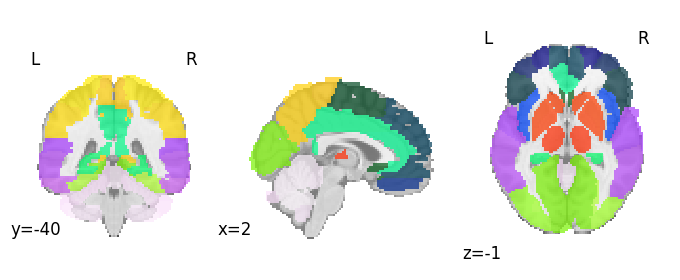

In [6]:
atlas_aal = datasets.fetch_atlas_aal() # secciona bien el hipocampo (buena para memoria), discreto
atlas_maps = atlas_aal.maps
plotting.plot_roi(atlas_maps, draw_cross=False, annotate=True)
# load labels for each atlas region
labels = atlas_aal.labels
print(labels[:10])

### Compute time series for each subj in each cluster

In [7]:
clusters_timeseries = {cluster: [] for cluster in cluster_data}
for cluster in cluster_data:
    cluster_subjs = cluster_data[cluster]
    for subj in cluster_subjs:
        subj_data = cluster_subjs[subj]
        subj_masker = NiftiLabelsMasker(labels_img=atlas_maps,
                            mask_img=str(subj_data['brainmask']),
                            smoothing_fwhm=6, # 3 x 3 x 3
                            low_pass=0.08,
                            high_pass=0.01,
                            t_r=2.,
                            standardize=False,
                            detrend=True,
                            memory='nilearn_cache', memory_level=2).fit()
        subj_confounds, subj_sample_mask = fmriprep.load_confounds_strategy(str(subj_data['funcdata']))
        subj_timeseries = subj_masker.transform(str(subj_data['funcdata']), confounds=subj_confounds, sample_mask=subj_sample_mask)
        clusters_timeseries[cluster].append(subj_timeseries)

/home/ftravi/.local/lib/python3.10/site-packages/scipy/ndimage/_measurements.py:684: RuntimeWarning: invalid value encountered in divide
  return sum / numpy.asanyarray(count).astype(numpy.float64)
/home/ftravi/.local/lib/python3.10/site-packages/nilearn/maskers/base_masker.py:106: UserWarning: Persisting input arguments took 0.76s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  region_signals, aux = cache(extraction_function, memory,
/home/ftravi/.local/lib/python3.10/site-packages/joblib/memory.py:779: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this beh

### Correlation matrix

In [15]:
clusters_correlation_matrices = {cluster: {'mean': None, 'all': None} for cluster in clusters_timeseries}
for cluster in clusters_timeseries:
    correlation_measure  = ConnectivityMeasure(kind='correlation')
    correlation_matrices = correlation_measure.fit_transform(clusters_timeseries[cluster])
    mean_correlation_matrix = correlation_measure.mean_
    clusters_correlation_matrices[cluster]['mean'] = mean_correlation_matrix
    clusters_correlation_matrices[cluster]['all'] = correlation_matrices

/home/ftravi/.local/lib/python3.10/site-packages/nilearn/connectome/connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
/home/ftravi/.local/lib/python3.10/site-packages/nilearn/connectome/connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
/home/ftravi

#### Alternative: manually compute correlation matrix weighted by the number of registered brain volumes

In [16]:
clusters_correlation_matrices = {cluster: {'mean': None, 'all': None} for cluster in clusters_timeseries}
for cluster in clusters_timeseries:
    correlation_measure  = ConnectivityMeasure(kind='correlation')
    correlation_matrices = correlation_measure.fit_transform(clusters_timeseries[cluster])
    corrmatrix_mean = np.zeros((correlation_matrices.shape[1], correlation_matrices.shape[2]))
    # Compute Hunter and Schmidt's (2004) pool correlation matrix
    cluster_subjids = list(cluster_data[cluster].keys())
    timepoints = []
    for i in range(correlation_matrices.shape[0]):
        subj_timepoints = image.load_img(cluster_data[cluster][cluster_subjids[i]]['funcdata']).shape[-1]
        if subj_timepoints == 190:
            print(f'Cluster {cluster} - Subject {cluster_subjids[i]} has {subj_timepoints} timepoints')
        corrmatrix_mean += correlation_matrices[i] * subj_timepoints
        timepoints.append(subj_timepoints)
    corrmatrix_mean /= np.sum(timepoints)
    clusters_correlation_matrices[cluster]['mean'] = corrmatrix_mean
    clusters_correlation_matrices[cluster]['all'] = correlation_matrices

/home/ftravi/.local/lib/python3.10/site-packages/nilearn/connectome/connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
/home/ftravi/.local/lib/python3.10/site-packages/nilearn/connectome/connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
/home/ftravi

Cluster 2 - Subject 28 has 190 timepoints


#### Q statistical test

In [9]:
def upper_triangulize(matrix):
    np.fill_diagonal(matrix, 0)
    for j in range(matrix.shape[1]):
        for i in range(j):
            matrix[j, i] = 0
    return matrix

Cluster 1 - Q: 386.63495569916114
Cluster 2 - Q: 388.6212634508232


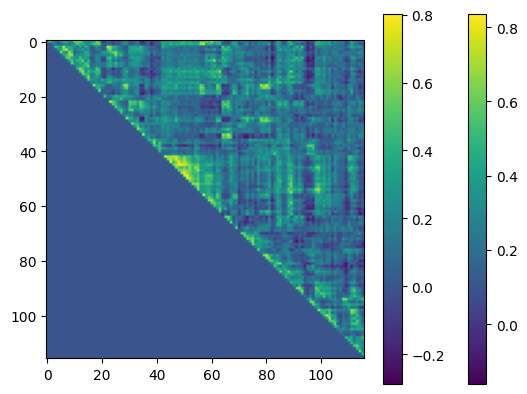

In [20]:
import matplotlib.pyplot as plt
for cluster in clusters_timeseries:
    mean_corrmatrix = upper_triangulize(clusters_correlation_matrices[cluster]['mean'].copy())
    all_corrmatrices = clusters_correlation_matrices[cluster]['all']
    for i in range(all_corrmatrices.shape[0]):
        all_corrmatrices[i] = upper_triangulize(all_corrmatrices[i].copy())
    Q = np.sum(np.sum(np.square(all_corrmatrices - mean_corrmatrix)) / (all_corrmatrices.shape[0] - 1))
    print(f'Cluster {cluster} - Q: {Q}')
    plt.colorbar(plt.imshow(mean_corrmatrix))

#### Plot pooled correlation matrices

Cluster 1


/home/ftravi/.local/lib/python3.10/site-packages/nilearn/plotting/matrix_plotting.py:120: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(mat, method=reorder)
/home/ftravi/.local/lib/python3.10/site-packages/nilearn/plotting/matrix_plotting.py:121: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  ordered_linkage = optimal_leaf_ordering(linkage_matrix, mat)


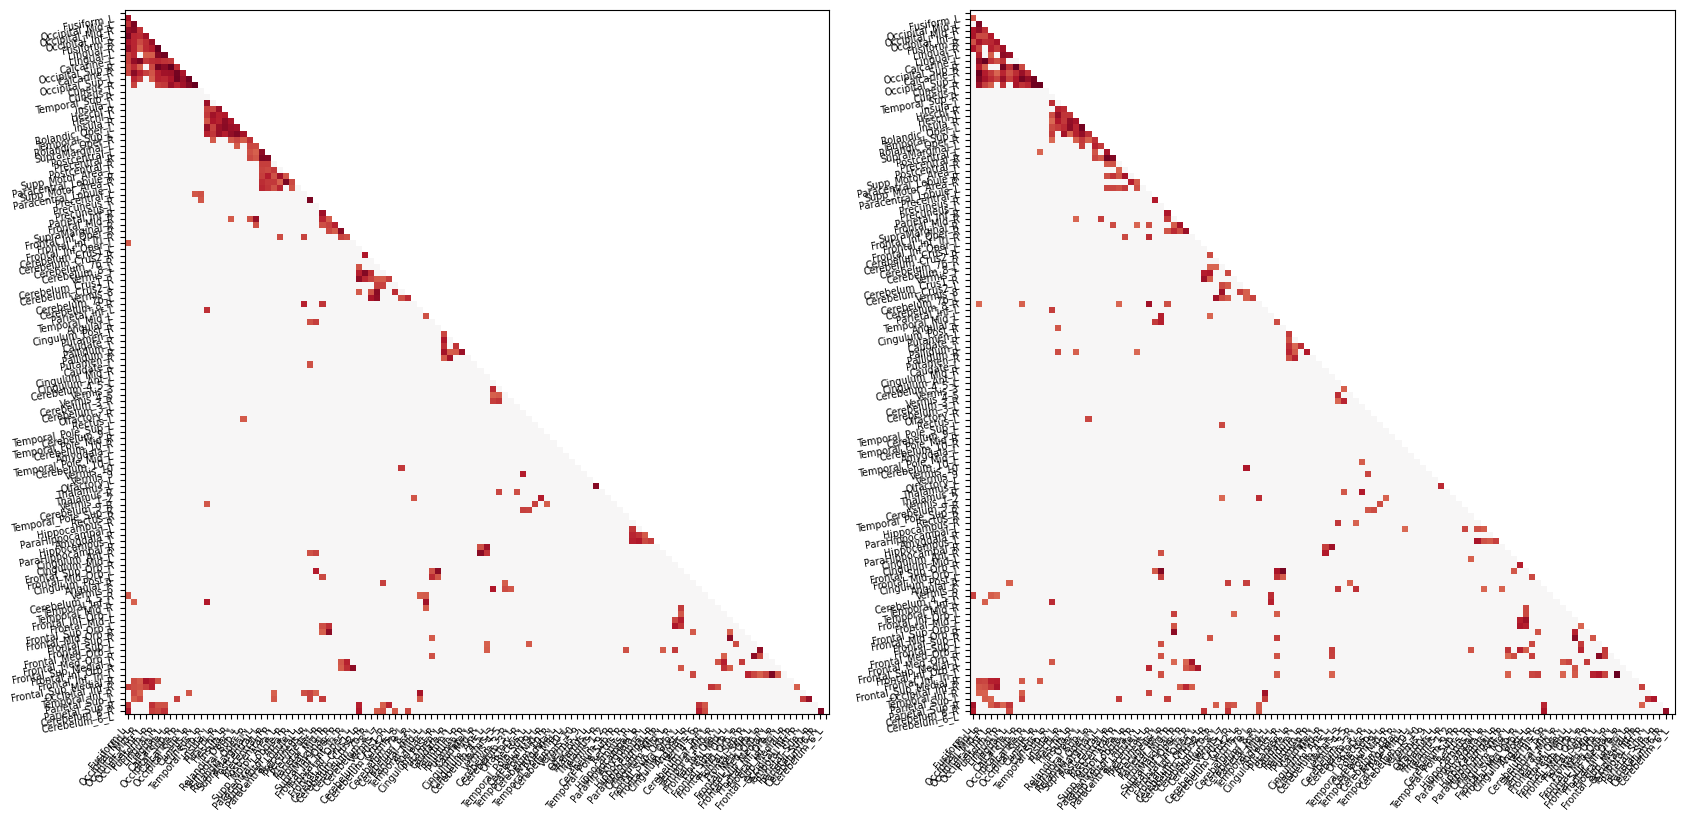

In [179]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))
######## CLUSTER 1 CORR MATRIX ########
cluster1_corrmatrix = clusters_correlation_matrices[1]['mean'].copy()
np.fill_diagonal(cluster1_corrmatrix, 0)
q = np.percentile(cluster1_corrmatrix, 95)
print('Cluster 1')
cluster1_corrmatrix[cluster1_corrmatrix < q] = 0
plotting.plot_matrix(cluster1_corrmatrix, axes=axes[0], labels=labels,
                     reorder=True, tri='lower', vmin=-0.8, vmax=0.8, colorbar=False)

######## CLUSTER 2 CORR MATRIX ########
cluster1_order = [tick.get_text() for tick in axes[0].get_xticklabels()]
# Get indices of the regions
regions_indices = [labels.index(region) for region in cluster1_order]
cluster2_corrmatrix = clusters_correlation_matrices[2]['mean'].copy()
np.fill_diagonal(cluster2_corrmatrix, 0)

q = np.percentile(cluster2_corrmatrix, 95)
perm = cluster2_corrmatrix[:, regions_indices]
perm = perm[regions_indices, :]
perm[perm < q] = 0
plotting.plot_matrix(perm, axes=axes[1], labels=cluster1_order,
                     reorder=False, tri='lower', vmin=-0.8, vmax=0.8, colorbar=False)
plt.show()

### Functional connectome

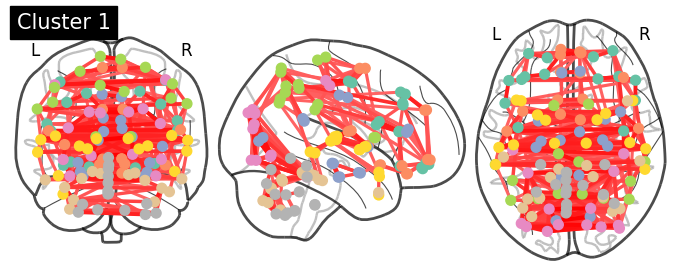

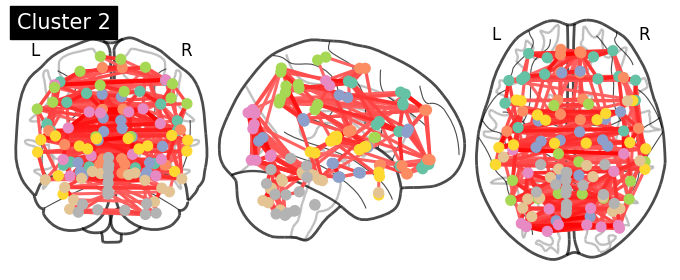

In [106]:
""" No tenemos las coordenadas del atlas, las buscamos """
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas_maps)
plotting.plot_connectome(cluster1_corrmatrix, coordinates, edge_threshold='95%', title='Cluster 1')
plotting.plot_connectome(cluster2_corrmatrix, coordinates, edge_threshold='95%', title='Cluster 2')

### Partial Correlation Matrix

In [11]:
clusters_partial_correlation_matrices = dict.fromkeys(clusters_timeseries)
for cluster in clusters_timeseries:
    partial_correlation_measure  = ConnectivityMeasure(kind='partial correlation')
    correlation_matrices = partial_correlation_measure.fit_transform(clusters_timeseries[cluster])
    mean_correlation_matrix = partial_correlation_measure.mean_
    clusters_partial_correlation_matrices[cluster] = mean_correlation_matrix

Cluster 1


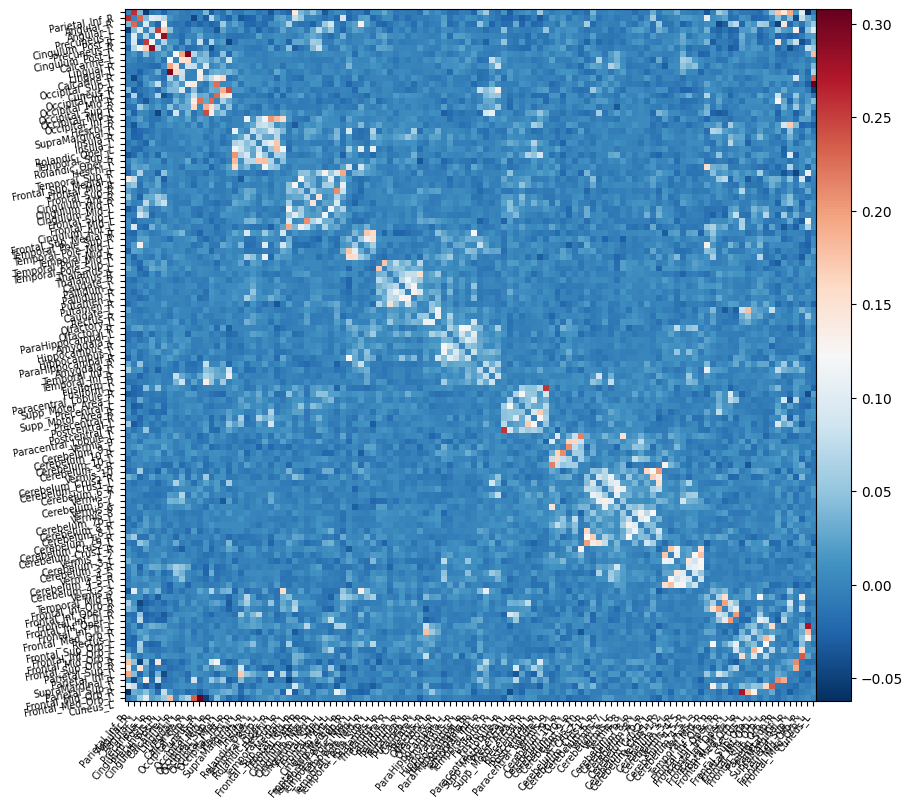

In [12]:
cluster1_partial_corrmatrix = clusters_partial_correlation_matrices[1]
np.fill_diagonal(cluster1_partial_corrmatrix, 0)
# Plot correlation matrix - note: matrix is ordered for block-like representation
print('Cluster 1')
plotting.plot_matrix(cluster1_partial_corrmatrix, figure=(10, 8), labels=labels,
                     reorder=True)

Cluster 2


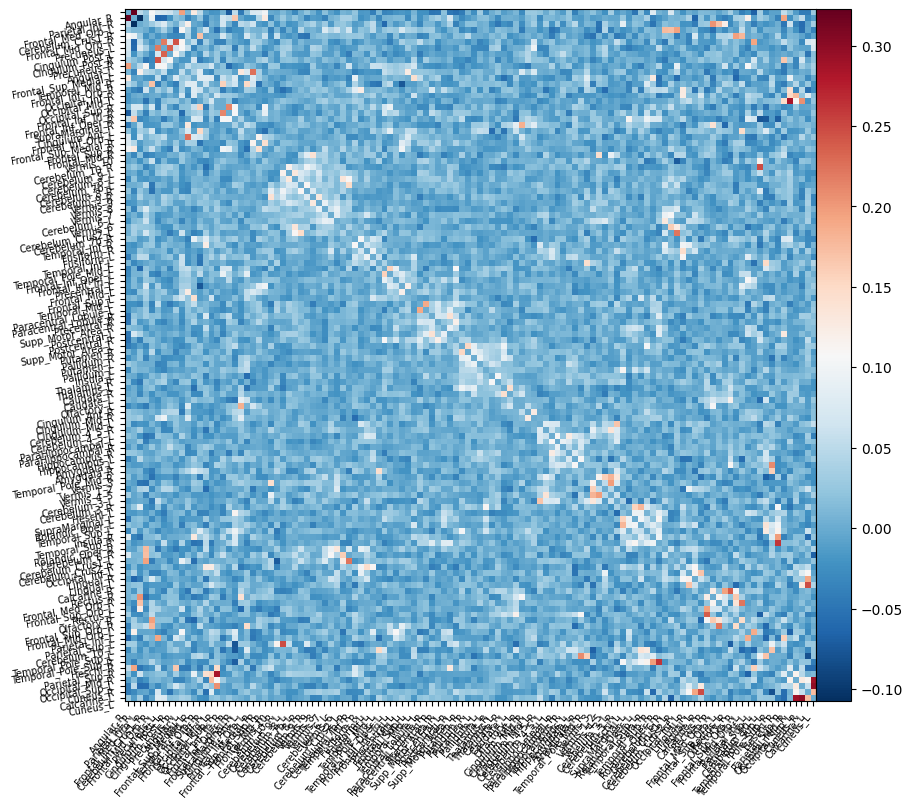

In [13]:
cluster2_partial_corrmatrix = clusters_partial_correlation_matrices[2]
np.fill_diagonal(cluster2_partial_corrmatrix, 0)
# Plot correlation matrix - note: matrix is ordered for block-like representation
print('Cluster 2')
plotting.plot_matrix(cluster2_partial_corrmatrix, figure=(10, 8), labels=labels,
                     reorder=True)

#### Functional connectome

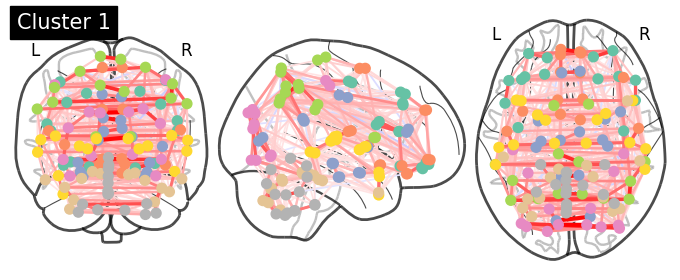

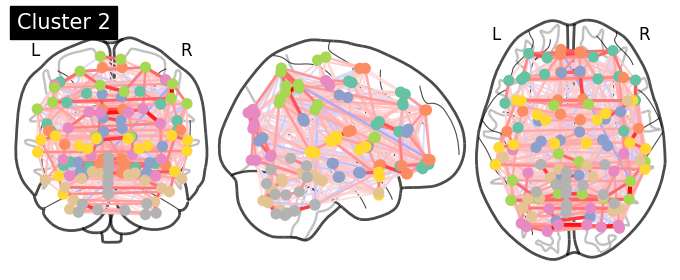

In [14]:
""" No tenemos las coordenadas del atlas, las buscamos """
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas_maps)
plotting.plot_connectome(cluster1_partial_corrmatrix, coordinates, edge_threshold='90%', title='Cluster 1')
plotting.plot_connectome(cluster2_partial_corrmatrix, coordinates, edge_threshold='90%', title='Cluster 2')

## Salience network
According to **"Resting state fMRI: A review on methods in resting state connectivity analysis and resting state networks"**

In [15]:
salience_network_labels = ['Insula_L', 'Insula_R', # Insular cortex
                          'Cingulum_Ant_L', 'Cingulum_Ant_R', # Anterior cingulate cortex (dACC)
                          'Supp_Motor_Area_L', 'Supp_Motor_Area_R', # (Pre)Supplementary motor area
                          ]

#### Get salience network nodes from AAL

[('Supp_Motor_Area_L', 2401), ('Supp_Motor_Area_R', 2402), ('Insula_L', 3001), ('Insula_R', 3002), ('Cingulum_Ant_L', 4001), ('Cingulum_Ant_R', 4002)]


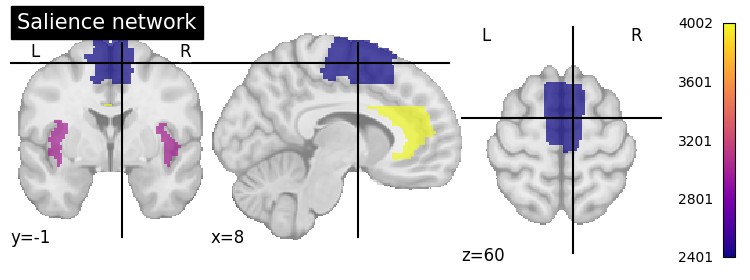

In [16]:
aal_img = image.load_img(atlas_aal.maps)
aal_affine = aal_img.affine
aal_data = aal_img.get_fdata()

sn_labels_indices = [int(atlas_aal.indices[atlas_aal.labels.index(label)])
                     for label in salience_network_labels]
sn_data = aal_data.copy()
sn_data[~np.isin(aal_data, sn_labels_indices)] = 0
sn_img = image.new_img_like(aal_img, sn_data, affine=aal_affine, copy_header=True)
plotting.plot_roi(sn_img, colorbar=True, cmap='plasma', title='Salience network')
sn_mapping = sorted(list(zip(salience_network_labels, sn_labels_indices)), key=lambda x: x[1])
print(sn_mapping)

### Compute time series for each subj in each cluster

In [17]:
clusters_sn_timeseries = {cluster: [] for cluster in cluster_data}
for cluster in cluster_data:
    cluster_subjs = cluster_data[cluster]
    for subj in cluster_subjs:
        subj_data = cluster_subjs[subj]
        subj_masker = NiftiLabelsMasker(labels_img=sn_img,
                            mask_img=str(subj_data['brainmask']),
                            smoothing_fwhm=9, # 3 x 3 x 3
                            low_pass=0.08,
                            high_pass=0.01,
                            t_r=2.,
                            standardize=False,
                            detrend=True,
                            memory='nilearn_cache', memory_level=2).fit()
        subj_confounds, subj_sample_mask = fmriprep.load_confounds_strategy(str(subj_data['funcdata']))
        subj_timeseries = subj_masker.transform(str(subj_data['funcdata']), confounds=subj_confounds, sample_mask=subj_sample_mask)
        clusters_sn_timeseries[cluster].append(subj_timeseries)

### Correlation matrix

In [18]:
clusters_sn_correlation_matrices = dict.fromkeys(clusters_sn_timeseries)
for cluster in clusters_timeseries:
    correlation_measure  = ConnectivityMeasure(kind='correlation')
    correlation_matrices = correlation_measure.fit_transform(clusters_sn_timeseries[cluster])
    mean_correlation_matrix = correlation_measure.mean_
    clusters_sn_correlation_matrices[cluster] = mean_correlation_matrix

Cluster 1


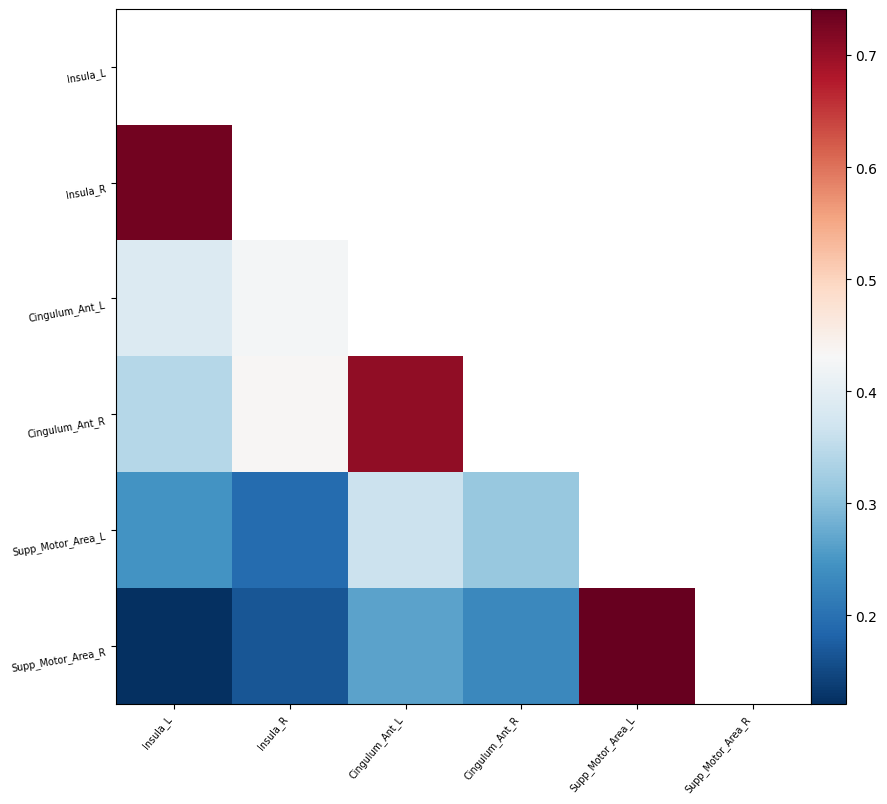

In [19]:
cluster1_sn_corrmatrix = clusters_sn_correlation_matrices[1]
np.fill_diagonal(cluster1_sn_corrmatrix, 0)
# Plot correlation matrix - note: matrix is ordered for block-like representation
print('Cluster 1')
plotting.plot_matrix(cluster1_sn_corrmatrix, figure=(10, 8), labels=salience_network_labels,
                     reorder=False, tri='lower')

Cluster 2


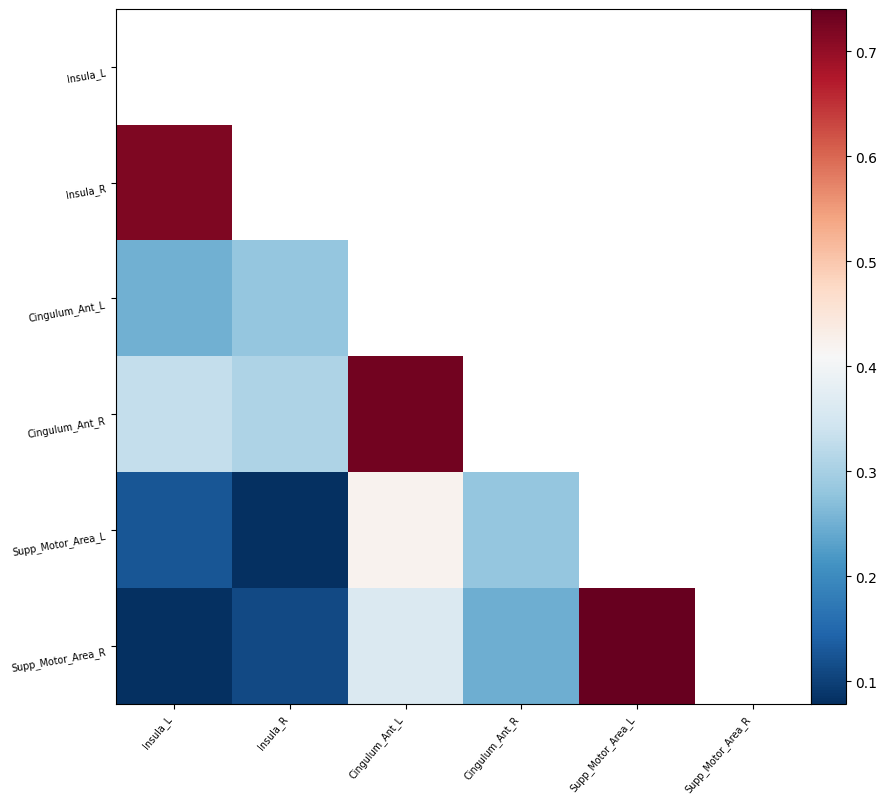

In [20]:
cluster2_sn_corrmatrix = clusters_sn_correlation_matrices[2]
np.fill_diagonal(cluster2_sn_corrmatrix, 0)
# Plot correlation matrix - note: matrix is ordered for block-like representation
print('Cluster 2')
plotting.plot_matrix(cluster2_sn_corrmatrix, figure=(10, 8), labels=salience_network_labels,
                     reorder=False, tri='lower', vmax=)

#### Functional connectome

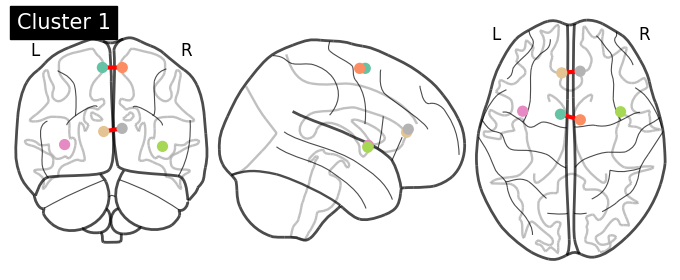

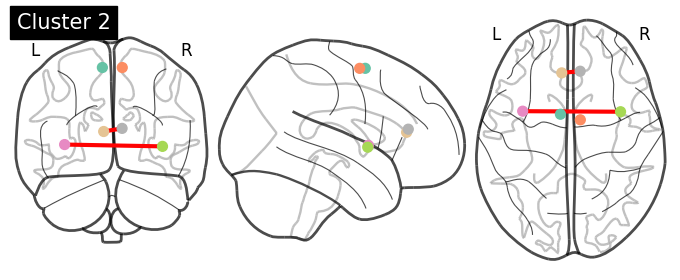

In [28]:
""" No tenemos las coordenadas del atlas, las buscamos """
coordinates = plotting.find_parcellation_cut_coords(labels_img=sn_img)
plotting.plot_connectome(cluster1_sn_corrmatrix, coordinates, edge_threshold='90%', title='Cluster 1')
plotting.plot_connectome(cluster2_sn_corrmatrix, coordinates, edge_threshold='90%', title='Cluster 2')

## Extracting brain networks with Dictionary Learning

In [22]:
from nilearn.decomposition import DictLearning
clusters_dict_learning = {cluster: {'funcdata': [],
                                    'confounds': [],
                                    'brainmasks': [] }
                          for cluster in cluster_data}
for cluster in cluster_data:
    cluster_subjs = cluster_data[cluster]
    for subj in cluster_subjs:
        subj_data = cluster_subjs[subj]
        subj_confounds, subj_sample_mask = fmriprep.load_confounds_strategy(str(subj_data['funcdata']))
        clusters_dict_learning[cluster]['funcdata'].append(str(subj_data['funcdata']))
        clusters_dict_learning[cluster]['confounds'].append(subj_confounds)
        clusters_dict_learning[cluster]['brainmasks'].append(str(subj_data['brainmask']))

#### Cluster 1

In [23]:
cluster1_masks = clusters_dict_learning[1]['brainmasks']
masker = MultiNiftiMasker(# mask_img=cluster1_masks[0],
                          standardize=True,
                          detrend=True,
                          high_pass=0.01,
                          low_pass=0.08,
                          t_r=2.,
                          smoothing_fwhm=9.,
                          memory='nilearn_cache', memory_level=2)
#masker.fit()

In [24]:
dict_learn = DictLearning(n_components=5,
                          high_pass=0.01,
                          low_pass=0.08,
                          t_r=2.,
                          mask=masker,
                          standardize=True,
                          smoothing_fwhm=9.,
                          random_state=42,
                          n_jobs=-1,
                          memory='nilearn_cache', memory_level=2)
dict_learn.fit(clusters_dict_learning[1]['funcdata'],
               confounds=clusters_dict_learning[1]['confounds'])

/home/ftravi/.local/lib/python3.10/site-packages/nilearn/maskers/_masker_validation.py:97: UserWarning: Overriding provided-default estimator parameters with provided masker parameters :
Parameter mask_strategy :
    Masker parameter background - overriding estimator parameter epi

  warnings.warn(warn_str)


ValueError: All masks should have the same affine

/home/ftravi/.local/lib/python3.10/site-packages/numpy/ma/core.py:2826: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


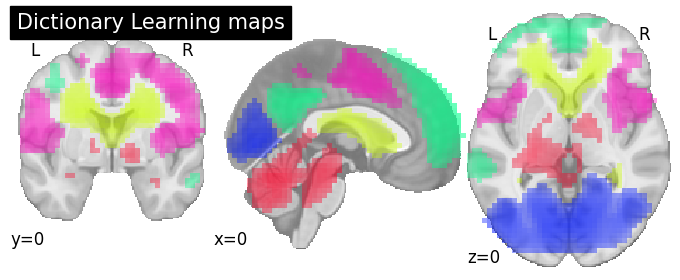

In [ ]:
components_img = dict_learn.components_img_
plotting.plot_prob_atlas(components_img, draw_cross=False, linewidths=None,
                         cut_coords=[0, 0, 0], title='Dictionary Learning maps')

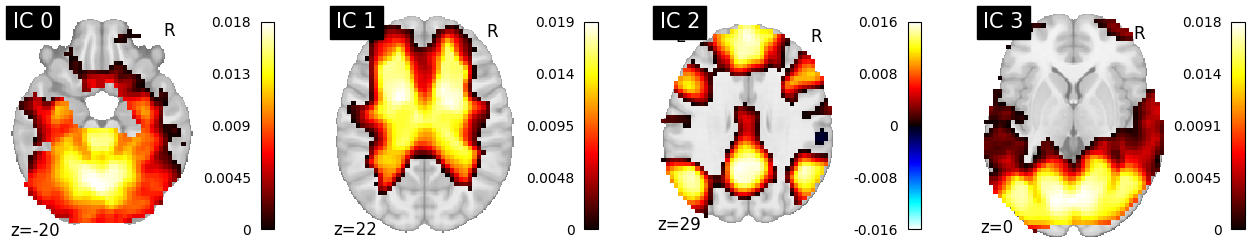

In [ ]:
import matplotlib.pyplot as plt
# Extract first few components
first_few_comp = components_img.slicer[..., :4]

# Plot first few components
fig = plt.figure(figsize=(16, 3))
for i, cur_img in enumerate(image.iter_img(first_few_comp)):
    ax = fig.add_subplot(1, 4, i + 1)
    plotting.plot_stat_map(cur_img, display_mode="z", title="IC %d" % i, 
                  cut_coords=1, colorbar=True, axes=ax)